# Эволюционный поиск правил Стандартной модели

Автоматический поиск набора правил RSL, которые порождают SM-подобную физику:
- **Генетический алгоритм** для эволюции наборов правил
- **Фитнес-функция** на основе SM-критериев
- **Симуляция отжига** для тонкой настройки

**Целевые критерии SM:**
1. 3 поколения фермионов (разные периоды Ω-циклов)
2. Сохранение зарядов (топологических инвариантов)
3. Калибровочные симметрии (U(1), SU(2), SU(3) аналоги)
4. Стабильные частицы + нестабильные резонансы
5. Взаимодействия с сохранением квантовых чисел

In [1]:
import sys
sys.path.insert(0, '..')

import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
from itertools import product, combinations
from typing import List, Dict, Tuple, Set, Optional, Callable
from dataclasses import dataclass, field
import random
import pickle
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

from world.core import Lattice, Rule, RuleSet, EvolutionEngine
from world.omega import CycleDetector, OmegaCycle
from world.rsl import TensionCalculator
from world.analysis import compute_winding_numbers

print("Модули загружены")

Модули загружены


/home/catman/Yandex.Disk/cuckoo/z/reals/libs/Experiments/Space/World/.conda/lib/python3.14/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Представление генома (набора правил)

In [2]:
@dataclass
class RuleGenome:
    """
    Геном = набор правил в виде битовой матрицы.
    
    Для паттернов длины L есть 2^L возможных паттернов.
    Матрица transition[i,j] = 1 означает правило: pattern_i → pattern_j
    
    Ограничения:
    - Обратимость: если transition[i,j]=1, то transition[j,i]=1
    - Каждый паттерн может иметь максимум один выход
    """
    pattern_length: int = 3
    transitions: np.ndarray = None  # 2^L x 2^L матрица
    
    def __post_init__(self):
        n = 2 ** self.pattern_length
        if self.transitions is None:
            self.transitions = np.zeros((n, n), dtype=np.int8)
    
    @property
    def n_patterns(self) -> int:
        return 2 ** self.pattern_length
    
    def add_rule(self, src: int, dst: int) -> bool:
        """Добавить правило src → dst (и обратное dst → src для обратимости)."""
        # Проверяем, что src и dst ещё не заняты
        if self.transitions[src].sum() > 0 or self.transitions[dst].sum() > 0:
            if src != dst:  # Идентичные правила можно добавлять
                return False
        self.transitions[src, dst] = 1
        self.transitions[dst, src] = 1
        return True
    
    def remove_rule(self, src: int, dst: int):
        """Удалить правило."""
        self.transitions[src, dst] = 0
        self.transitions[dst, src] = 0
    
    def get_rules(self) -> List[Tuple[int, int]]:
        """Получить список активных правил."""
        rules = []
        seen = set()
        for i in range(self.n_patterns):
            for j in range(self.n_patterns):
                if self.transitions[i, j] == 1:
                    pair = (min(i,j), max(i,j))
                    if pair not in seen:
                        seen.add(pair)
                        rules.append((i, j))
        return rules
    
    def to_ruleset(self) -> RuleSet:
        """Конвертировать геном в RuleSet для симуляции."""
        rules = []
        for idx, (src, dst) in enumerate(self.get_rules()):
            pattern = self._idx_to_pattern(src)
            replacement = self._idx_to_pattern(dst)
            rules.append(Rule(
                name=f"r{idx}_{src}_{dst}",
                pattern=pattern,
                replacement=replacement,
                priority=idx
            ))
            # Обратное правило (если не идентичное)
            if src != dst:
                rules.append(Rule(
                    name=f"r{idx}_{dst}_{src}",
                    pattern=replacement,
                    replacement=pattern,
                    priority=idx
                ))
        return RuleSet(rules) if rules else RuleSet([Rule(
            name="identity",
            pattern=np.array([1,1,1], dtype=np.int8),
            replacement=np.array([1,1,1], dtype=np.int8)
        )])
    
    def _idx_to_pattern(self, idx: int) -> np.ndarray:
        """Индекс → паттерн как numpy array."""
        bits = [(idx >> i) & 1 for i in range(self.pattern_length)]
        return np.array([1 if b else -1 for b in bits], dtype=np.int8)
    
    def _pattern_to_idx(self, pattern: np.ndarray) -> int:
        """Паттерн → индекс."""
        idx = 0
        for i, p in enumerate(pattern):
            if p > 0:
                idx |= (1 << i)
        return idx
    
    def copy(self) -> 'RuleGenome':
        """Создать копию генома."""
        new = RuleGenome(self.pattern_length)
        new.transitions = self.transitions.copy()
        return new
    
    def __repr__(self):
        rules = self.get_rules()
        return f"RuleGenome({len(rules)} rules)"


# Тест
genome = RuleGenome(pattern_length=3)
genome.add_rule(0, 7)  # --- ↔ +++
genome.add_rule(1, 1)  # --+ → --+ (идентичное)
print(f"Геном: {genome}")
print(f"Правила: {genome.get_rules()}")
ruleset = genome.to_ruleset()
print(f"RuleSet: {len(ruleset)} правил")

Геном: RuleGenome(2 rules)
Правила: [(0, 7), (1, 1)]
RuleSet: 3 правил


## 2. Фитнес-функция (SM-критерии)

In [3]:
@dataclass
class SMFitness:
    """
    Фитнес-функция для оценки SM-подобности набора правил.
    
    Компоненты фитнеса:
    - cycle_diversity: Разнообразие периодов Ω-циклов (аналог поколений)
    - cycle_count: Количество обнаруженных циклов (частиц)
    - charge_conservation: Сохранение топологических зарядов
    - stability: Долгоживущие структуры
    - interactions: Наличие взаимодействий между циклами
    - symmetry: Дискретные симметрии (Z2, Z3 и т.д.)
    """
    
    # Веса компонент
    weights: Dict[str, float] = field(default_factory=lambda: {
        'cycle_diversity': 3.0,      # Хотим 3+ типа циклов (поколения)
        'cycle_count': 1.0,          # Достаточное число частиц
        'charge_conservation': 2.0,  # Критично для SM
        'stability': 1.5,            # Стабильные частицы
        'nontrivial_dynamics': 2.0,  # Не тривиальная эволюция
        'interaction_richness': 1.5, # Взаимодействия
    })
    
    # Параметры симуляции
    lattice_size: int = 200
    max_steps: int = 100
    n_trials: int = 5
    
    def __post_init__(self):
        self.tension_calc = TensionCalculator()
    
    def evaluate(self, genome: RuleGenome) -> Tuple[float, Dict[str, float]]:
        """
        Вычислить фитнес генома.
        
        Returns:
            total_fitness, component_scores
        """
        ruleset = genome.to_ruleset()
        engine = EvolutionEngine(ruleset)
        
        # Аккумуляторы метрик
        all_periods = []
        all_cycle_counts = []
        charge_violations = 0
        total_steps_run = 0
        interaction_events = 0
        
        for trial in range(self.n_trials):
            # Случайное начальное состояние
            lattice = Lattice.random(self.lattice_size, p_plus=0.5, seed=trial*1000)
            
            # Запуск эволюции
            result = engine.run(lattice, self.max_steps, store_history=True)
            total_steps_run += len(result.history)
            
            # Детекция циклов
            detector = CycleDetector(window_size=5, max_period=50)
            for t, state in enumerate(result.history):
                detector.update(state.sites, t)
            
            cycles = detector.detected_cycles
            all_cycle_counts.append(len(cycles))
            all_periods.extend([c.period for c in cycles])
            
            # Проверка сохранения заряда
            if len(result.history) >= 2:
                q0 = self._compute_charges(result.history[0].sites)
                qf = self._compute_charges(result.history[-1].sites)
                if q0['parity'] != qf['parity']:
                    charge_violations += 1
            
            # Подсчёт взаимодействий (изменение числа циклов)
            if len(cycles) > 1:
                interaction_events += 1
        
        # Вычисление компонент фитнеса
        scores = {}
        
        # 1. Разнообразие периодов (хотим 3+ разных)
        unique_periods = len(set(all_periods)) if all_periods else 0
        scores['cycle_diversity'] = min(unique_periods / 3.0, 1.0) * 10
        
        # 2. Количество циклов
        avg_cycles = np.mean(all_cycle_counts) if all_cycle_counts else 0
        scores['cycle_count'] = min(avg_cycles / 10.0, 1.0) * 10
        
        # 3. Сохранение заряда
        conservation_rate = 1.0 - charge_violations / self.n_trials
        scores['charge_conservation'] = conservation_rate * 10
        
        # 4. Стабильность (длинные эволюции)
        avg_steps = total_steps_run / self.n_trials
        scores['stability'] = min(avg_steps / self.max_steps, 1.0) * 10
        
        # 5. Нетривиальная динамика (не застревает сразу)
        nontrivial = 1.0 if avg_steps > 5 else avg_steps / 5.0
        scores['nontrivial_dynamics'] = nontrivial * 10
        
        # 6. Взаимодействия
        scores['interaction_richness'] = min(interaction_events / self.n_trials, 1.0) * 10
        
        # Общий фитнес
        total = sum(scores[k] * self.weights[k] for k in scores)
        
        return total, scores
    
    def _compute_charges(self, sites: np.ndarray) -> Dict[str, int]:
        """Вычислить топологические заряды."""
        domain_walls = np.sum(sites[:-1] != sites[1:])
        n_minus = np.sum(sites == -1)
        return {
            'domain_walls': domain_walls,
            'parity': n_minus % 2,
            'walls_mod2': domain_walls % 2
        }


# Тест фитнес-функции
fitness_fn = SMFitness(lattice_size=100, max_steps=50, n_trials=3)
score, components = fitness_fn.evaluate(genome)
print(f"Фитнес: {score:.2f}")
for k, v in components.items():
    print(f"  {k}: {v:.2f}")

Фитнес: 69.83
  cycle_diversity: 3.33
  cycle_count: 10.00
  charge_conservation: 6.67
  stability: 1.00
  nontrivial_dynamics: 10.00
  interaction_richness: 10.00


## 3. Генетические операторы

In [4]:
class GeneticOperators:
    """Операторы мутации и кроссовера для геномов правил."""
    
    @staticmethod
    def random_genome(pattern_length: int = 3, n_rules: int = None) -> RuleGenome:
        """Создать случайный геном."""
        genome = RuleGenome(pattern_length)
        n = genome.n_patterns
        
        if n_rules is None:
            n_rules = random.randint(2, n // 2)
        
        # Случайно выбираем пары для правил
        available = list(range(n))
        random.shuffle(available)
        
        for _ in range(n_rules):
            if len(available) < 2:
                break
            
            # Случайно: идентичное или обменное правило
            if random.random() < 0.3:  # 30% идентичных
                src = available.pop()
                genome.add_rule(src, src)
            else:
                src = available.pop()
                dst = available.pop()
                genome.add_rule(src, dst)
        
        return genome
    
    @staticmethod
    def mutate(genome: RuleGenome, mutation_rate: float = 0.2) -> RuleGenome:
        """Мутация генома."""
        new_genome = genome.copy()
        n = new_genome.n_patterns
        
        for _ in range(max(1, int(n * mutation_rate))):
            mutation_type = random.choice(['add', 'remove', 'modify'])
            
            if mutation_type == 'add':
                # Добавить новое правило
                src = random.randint(0, n-1)
                dst = random.randint(0, n-1)
                new_genome.add_rule(src, dst)
                
            elif mutation_type == 'remove':
                # Удалить существующее правило
                rules = new_genome.get_rules()
                if rules:
                    src, dst = random.choice(rules)
                    new_genome.remove_rule(src, dst)
                    
            else:  # modify
                # Изменить существующее правило
                rules = new_genome.get_rules()
                if rules:
                    src, dst = random.choice(rules)
                    new_genome.remove_rule(src, dst)
                    new_dst = random.randint(0, n-1)
                    new_genome.add_rule(src, new_dst)
        
        return new_genome
    
    @staticmethod
    def crossover(parent1: RuleGenome, parent2: RuleGenome) -> RuleGenome:
        """Кроссовер двух геномов."""
        child = RuleGenome(parent1.pattern_length)
        
        # Объединяем правила от обоих родителей
        rules1 = set(parent1.get_rules())
        rules2 = set(parent2.get_rules())
        
        all_rules = list(rules1 | rules2)
        random.shuffle(all_rules)
        
        # Случайно выбираем подмножество
        n_rules = random.randint(1, len(all_rules))
        for src, dst in all_rules[:n_rules]:
            child.add_rule(src, dst)
        
        return child


# Тест операторов
g1 = GeneticOperators.random_genome()
g2 = GeneticOperators.random_genome()
print(f"Родитель 1: {g1}, правила: {g1.get_rules()}")
print(f"Родитель 2: {g2}, правила: {g2.get_rules()}")

child = GeneticOperators.crossover(g1, g2)
print(f"Потомок: {child}, правила: {child.get_rules()}")

mutant = GeneticOperators.mutate(g1)
print(f"Мутант: {mutant}, правила: {mutant.get_rules()}")

Родитель 1: RuleGenome(2 rules), правила: [(0, 4), (3, 6)]
Родитель 2: RuleGenome(2 rules), правила: [(0, 1), (3, 7)]
Потомок: RuleGenome(1 rules), правила: [(0, 1)]
Мутант: RuleGenome(1 rules), правила: [(3, 6)]


## 4. Эволюционный алгоритм

In [5]:
class EvolutionarySearch:
    """
    Эволюционный поиск SM-подобных правил.
    
    Алгоритм:
    1. Инициализация случайной популяции
    2. Оценка фитнеса каждого генома
    3. Селекция лучших (турнирная)
    4. Кроссовер и мутация
    5. Элитизм (сохранение лучших)
    6. Повторение до сходимости
    """
    
    def __init__(
        self,
        population_size: int = 50,
        elite_size: int = 5,
        mutation_rate: float = 0.3,
        crossover_rate: float = 0.7,
        tournament_size: int = 3,
        pattern_length: int = 3,
    ):
        self.population_size = population_size
        self.elite_size = elite_size
        self.mutation_rate = mutation_rate
        self.crossover_rate = crossover_rate
        self.tournament_size = tournament_size
        self.pattern_length = pattern_length
        
        self.fitness_fn = SMFitness(lattice_size=150, max_steps=80, n_trials=5)
        self.population: List[Tuple[RuleGenome, float, Dict]] = []
        self.history = {'best': [], 'avg': [], 'diversity': []}
        
    def initialize_population(self):
        """Инициализация случайной популяции."""
        self.population = []
        for _ in range(self.population_size):
            genome = GeneticOperators.random_genome(self.pattern_length)
            fitness, components = self.fitness_fn.evaluate(genome)
            self.population.append((genome, fitness, components))
        
        # Сортировка по фитнесу
        self.population.sort(key=lambda x: x[1], reverse=True)
    
    def tournament_select(self) -> RuleGenome:
        """Турнирная селекция."""
        candidates = random.sample(self.population, self.tournament_size)
        winner = max(candidates, key=lambda x: x[1])
        return winner[0].copy()
    
    def evolve_generation(self):
        """Эволюция одного поколения."""
        new_population = []
        
        # Элитизм: сохраняем лучших
        for genome, fitness, components in self.population[:self.elite_size]:
            new_population.append((genome.copy(), fitness, components))
        
        # Генерируем остальных через кроссовер и мутацию
        while len(new_population) < self.population_size:
            if random.random() < self.crossover_rate:
                parent1 = self.tournament_select()
                parent2 = self.tournament_select()
                child = GeneticOperators.crossover(parent1, parent2)
            else:
                child = self.tournament_select()
            
            if random.random() < self.mutation_rate:
                child = GeneticOperators.mutate(child, 0.2)
            
            fitness, components = self.fitness_fn.evaluate(child)
            new_population.append((child, fitness, components))
        
        # Сортировка
        new_population.sort(key=lambda x: x[1], reverse=True)
        self.population = new_population[:self.population_size]
        
        # Запись истории
        fitnesses = [p[1] for p in self.population]
        self.history['best'].append(max(fitnesses))
        self.history['avg'].append(np.mean(fitnesses))
        
        # Разнообразие (число уникальных геномов)
        unique = len(set(str(g.get_rules()) for g, _, _ in self.population))
        self.history['diversity'].append(unique)
    
    def run(self, n_generations: int = 100, verbose: bool = True) -> RuleGenome:
        """Запуск эволюции."""
        if verbose:
            print("Инициализация популяции...")
        self.initialize_population()
        
        best_ever = self.population[0]
        
        iterator = tqdm(range(n_generations), desc="Эволюция") if verbose else range(n_generations)
        
        for gen in iterator:
            self.evolve_generation()
            
            current_best = self.population[0]
            if current_best[1] > best_ever[1]:
                best_ever = current_best
            
            if verbose and gen % 10 == 0:
                tqdm.write(f"Gen {gen}: best={current_best[1]:.2f}, avg={self.history['avg'][-1]:.2f}, diversity={self.history['diversity'][-1]}")
        
        return best_ever
    
    def get_best(self, n: int = 5) -> List[Tuple[RuleGenome, float, Dict]]:
        """Получить n лучших геномов."""
        return self.population[:n]


print("Класс EvolutionarySearch определён")

Класс EvolutionarySearch определён


## 5. Запуск эволюционного поиска

In [6]:
# Создаём и запускаем поиск
search = EvolutionarySearch(
    population_size=30,
    elite_size=3,
    mutation_rate=0.4,
    crossover_rate=0.6,
    pattern_length=3
)

# Запуск (может занять несколько минут)
best = search.run(n_generations=50, verbose=True)

print(f"\n=== ЛУЧШИЙ РЕЗУЛЬТАТ ===")
print(f"Фитнес: {best[1]:.2f}")
print(f"Компоненты:")
for k, v in best[2].items():
    print(f"  {k}: {v:.2f}")

Инициализация популяции...


Эволюция:   2%|▏         | 1/50 [00:11<09:39, 11.83s/it]

Gen 0: best=97.96, avg=83.64, diversity=25


Эволюция:  22%|██▏       | 11/50 [08:56<47:32, 73.14s/it]

Gen 10: best=105.80, avg=87.93, diversity=7


Эволюция:  42%|████▏     | 21/50 [21:27<32:55, 68.12s/it]

Gen 20: best=105.80, avg=80.75, diversity=6


Эволюция:  62%|██████▏   | 31/50 [31:23<19:51, 62.74s/it]

Gen 30: best=105.80, avg=87.17, diversity=8


Эволюция:  82%|████████▏ | 41/50 [40:53<08:03, 53.71s/it]

Gen 40: best=105.80, avg=84.78, diversity=10


Эволюция: 100%|██████████| 50/50 [49:39<00:00, 59.59s/it]


=== ЛУЧШИЙ РЕЗУЛЬТАТ ===
Фитнес: 105.80
Компоненты:
  cycle_diversity: 10.00
  cycle_count: 10.00
  charge_conservation: 10.00
  stability: 7.20
  nontrivial_dynamics: 10.00
  interaction_richness: 10.00


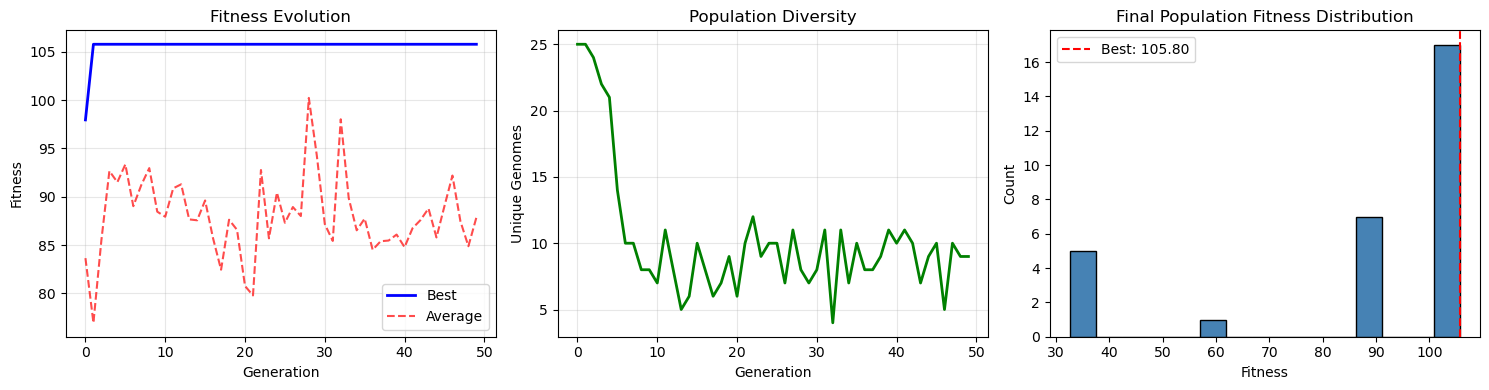

In [7]:
# Визуализация эволюции
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Фитнес
axes[0].plot(search.history['best'], 'b-', label='Best', linewidth=2)
axes[0].plot(search.history['avg'], 'r--', label='Average', alpha=0.7)
axes[0].set_xlabel('Generation')
axes[0].set_ylabel('Fitness')
axes[0].set_title('Fitness Evolution')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Разнообразие
axes[1].plot(search.history['diversity'], 'g-', linewidth=2)
axes[1].set_xlabel('Generation')
axes[1].set_ylabel('Unique Genomes')
axes[1].set_title('Population Diversity')
axes[1].grid(True, alpha=0.3)

# Распределение фитнеса в финальной популяции
final_fitness = [p[1] for p in search.population]
axes[2].hist(final_fitness, bins=15, color='steelblue', edgecolor='black')
axes[2].axvline(best[1], color='red', linestyle='--', label=f'Best: {best[1]:.2f}')
axes[2].set_xlabel('Fitness')
axes[2].set_ylabel('Count')
axes[2].set_title('Final Population Fitness Distribution')
axes[2].legend()

plt.tight_layout()
plt.show()

## 6. Анализ лучших правил


=== Best SM-like Rules ===

Правила (2):
  ++- ↔ -++
  +++ → +++

Эволюция: 75 шагов, 2402 применений
Обнаружено Ω-циклов: 671
Периоды: Counter({2: 37, 4: 35, 6: 33, 8: 32, 12: 32, 10: 31, 14: 31, 16: 29, 18: 27, 20: 26, 3: 24, 22: 24, 5: 23, 24: 23, 26: 21, 11: 20, 15: 19, 7: 18, 17: 18, 28: 17, 9: 16, 13: 16, 19: 16, 21: 15, 30: 15, 25: 13, 23: 12, 32: 12, 27: 7, 29: 7, 31: 6, 34: 6, 35: 4, 33: 3, 36: 3})
Обнаружено Ω-циклов: 671
Периоды: Counter({2: 37, 4: 35, 6: 33, 8: 32, 12: 32, 10: 31, 14: 31, 16: 29, 18: 27, 20: 26, 3: 24, 22: 24, 5: 23, 24: 23, 26: 21, 11: 20, 15: 19, 7: 18, 17: 18, 28: 17, 9: 16, 13: 16, 19: 16, 21: 15, 30: 15, 25: 13, 23: 12, 32: 12, 27: 7, 29: 7, 31: 6, 34: 6, 35: 4, 33: 3, 36: 3})


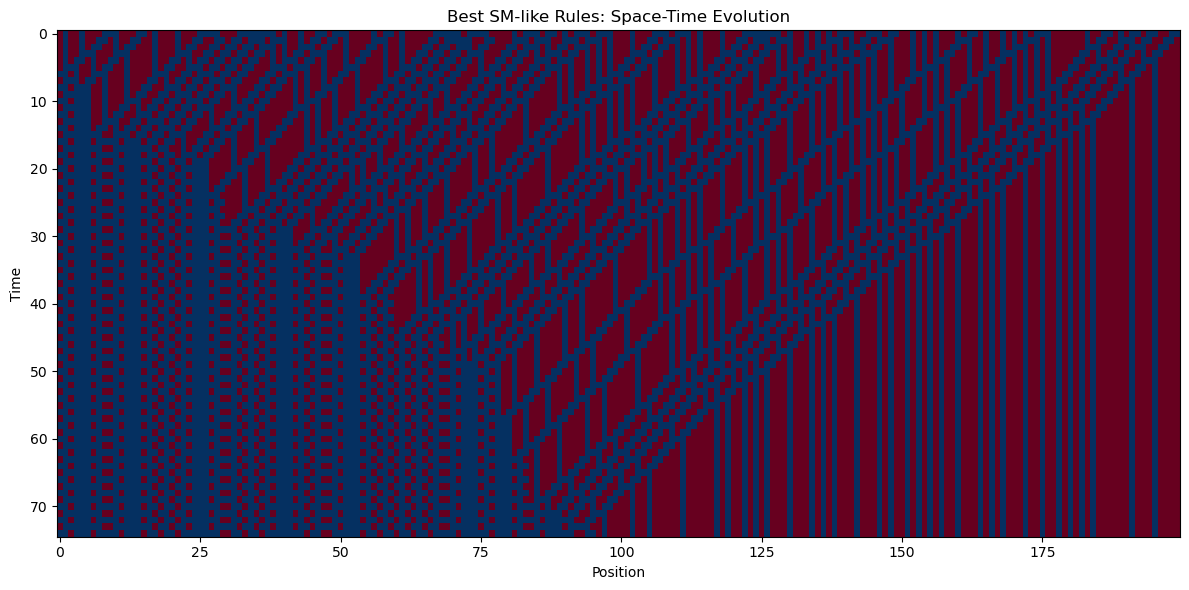

In [8]:
def analyze_genome(genome: RuleGenome, name: str = "Genome"):
    """Детальный анализ генома."""
    print(f"\n=== {name} ===")
    
    # Показываем правила
    rules = genome.get_rules()
    print(f"\nПравила ({len(rules)}):")
    for src, dst in rules:
        src_pat = ''.join(['+' if x == 1 else '-' for x in genome._idx_to_pattern(src)])
        dst_pat = ''.join(['+' if x == 1 else '-' for x in genome._idx_to_pattern(dst)])
        arrow = '↔' if src != dst else '→'
        print(f"  {src_pat} {arrow} {dst_pat}")
    
    # Запускаем симуляцию
    ruleset = genome.to_ruleset()
    engine = EvolutionEngine(ruleset)
    lattice = Lattice.random(200, p_plus=0.5, seed=42)
    result = engine.run(lattice, max_steps=100, store_history=True)
    
    print(f"\nЭволюция: {len(result.history)} шагов, {result.stats.rules_applied} применений")
    
    # Детекция циклов
    detector = CycleDetector(window_size=5, max_period=50)
    for t, state in enumerate(result.history):
        detector.update(state.sites, t)
    
    cycles = detector.detected_cycles
    print(f"Обнаружено Ω-циклов: {len(cycles)}")
    
    if cycles:
        periods = [c.period for c in cycles]
        print(f"Периоды: {Counter(periods)}")
    
    # Визуализация
    if len(result.history) > 1:
        history_array = np.array([h.sites for h in result.history])
        
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.imshow(history_array, cmap='RdBu', aspect='auto', vmin=-1, vmax=1)
        ax.set_xlabel('Position')
        ax.set_ylabel('Time')
        ax.set_title(f'{name}: Space-Time Evolution')
        plt.tight_layout()
        plt.show()
    
    return cycles

# Анализ лучшего генома
best_genome = best[0]
cycles = analyze_genome(best_genome, "Best SM-like Rules")

In [9]:
# Анализ топ-5 геномов
print("=" * 60)
print("ТОП-5 ГЕНОМОВ")
print("=" * 60)

top5 = search.get_best(5)
for i, (genome, fitness, components) in enumerate(top5):
    print(f"\n--- #{i+1} (fitness={fitness:.2f}) ---")
    rules = genome.get_rules()
    for src, dst in rules:
        src_pat = ''.join(['+' if x == 1 else '-' for x in genome._idx_to_pattern(src)])
        dst_pat = ''.join(['+' if x == 1 else '-' for x in genome._idx_to_pattern(dst)])
        arrow = '↔' if src != dst else '→'
        print(f"    {src_pat} {arrow} {dst_pat}")
    print(f"  Компоненты: diversity={components['cycle_diversity']:.1f}, cycles={components['cycle_count']:.1f}, charge={components['charge_conservation']:.1f}")

ТОП-5 ГЕНОМОВ

--- #1 (fitness=105.80) ---
    ++- ↔ -++
    +++ → +++
  Компоненты: diversity=10.0, cycles=10.0, charge=10.0

--- #2 (fitness=105.80) ---
    ++- ↔ -++
    +++ → +++
  Компоненты: diversity=10.0, cycles=10.0, charge=10.0

--- #3 (fitness=105.80) ---
    ++- ↔ -++
    +++ → +++
  Компоненты: diversity=10.0, cycles=10.0, charge=10.0

--- #4 (fitness=105.80) ---
    ++- ↔ -++
    +++ → +++
  Компоненты: diversity=10.0, cycles=10.0, charge=10.0

--- #5 (fitness=105.80) ---
    ++- ↔ -++
    +++ → +++
  Компоненты: diversity=10.0, cycles=10.0, charge=10.0


## 7. Локальный поиск (Simulated Annealing)

In [10]:
def simulated_annealing(
    initial_genome: RuleGenome,
    fitness_fn: SMFitness,
    max_iterations: int = 200,
    initial_temp: float = 10.0,
    cooling_rate: float = 0.95,
    verbose: bool = True
) -> Tuple[RuleGenome, float, Dict]:
    """
    Simulated Annealing для тонкой настройки генома.
    """
    current = initial_genome.copy()
    current_fitness, current_components = fitness_fn.evaluate(current)
    
    best = current.copy()
    best_fitness = current_fitness
    best_components = current_components
    
    temp = initial_temp
    history = {'fitness': [current_fitness], 'temp': [temp]}
    
    iterator = tqdm(range(max_iterations), desc="Annealing") if verbose else range(max_iterations)
    
    for i in iterator:
        # Генерируем соседа
        neighbor = GeneticOperators.mutate(current, 0.1)
        neighbor_fitness, neighbor_components = fitness_fn.evaluate(neighbor)
        
        # Принимаем/отклоняем
        delta = neighbor_fitness - current_fitness
        
        if delta > 0 or random.random() < np.exp(delta / temp):
            current = neighbor
            current_fitness = neighbor_fitness
            current_components = neighbor_components
            
            if current_fitness > best_fitness:
                best = current.copy()
                best_fitness = current_fitness
                best_components = current_components
        
        # Охлаждение
        temp *= cooling_rate
        
        history['fitness'].append(current_fitness)
        history['temp'].append(temp)
        
        if verbose and i % 50 == 0:
            tqdm.write(f"Iter {i}: current={current_fitness:.2f}, best={best_fitness:.2f}, temp={temp:.3f}")
    
    return best, best_fitness, best_components, history


# Применяем SA к лучшему геному
print("Запуск Simulated Annealing для тонкой настройки...")
refined, refined_fitness, refined_components, sa_history = simulated_annealing(
    best_genome,
    SMFitness(lattice_size=150, max_steps=100, n_trials=5),
    max_iterations=100,
    initial_temp=5.0,
    cooling_rate=0.95
)

print(f"\nИсходный фитнес: {best[1]:.2f}")
print(f"Улучшенный фитнес: {refined_fitness:.2f}")
print(f"Улучшение: {refined_fitness - best[1]:.2f}")

Запуск Simulated Annealing для тонкой настройки...


Annealing:   2%|▏         | 2/100 [00:00<00:13,  7.23it/s]

Iter 0: current=103.64, best=103.64, temp=4.750


Annealing:  53%|█████▎    | 53/100 [00:48<00:32,  1.46it/s]

Iter 50: current=102.44, best=103.64, temp=0.365


Annealing: 100%|██████████| 100/100 [01:26<00:00,  1.15it/s]


Исходный фитнес: 105.80
Улучшенный фитнес: 103.64
Улучшение: -2.16


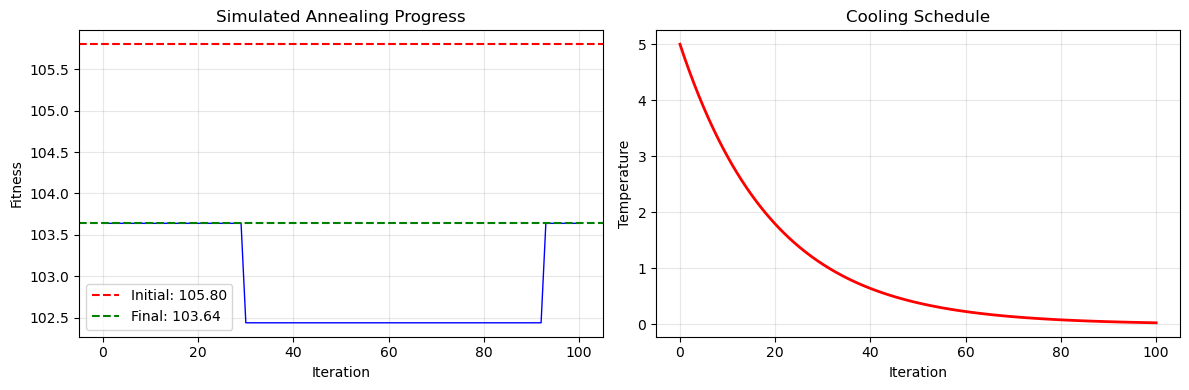

In [11]:
# Визуализация SA
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(sa_history['fitness'], 'b-', linewidth=1)
axes[0].axhline(best[1], color='red', linestyle='--', label=f'Initial: {best[1]:.2f}')
axes[0].axhline(refined_fitness, color='green', linestyle='--', label=f'Final: {refined_fitness:.2f}')
axes[0].set_xlabel('Iteration')
axes[0].set_ylabel('Fitness')
axes[0].set_title('Simulated Annealing Progress')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(sa_history['temp'], 'r-', linewidth=2)
axes[1].set_xlabel('Iteration')
axes[1].set_ylabel('Temperature')
axes[1].set_title('Cooling Schedule')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


=== REFINED SM-like Rules (after SA) ===

Правила (2):
  ++- ↔ -++
  +++ → +++

Эволюция: 75 шагов, 2402 применений
Обнаружено Ω-циклов: 671
Периоды: Counter({2: 37, 4: 35, 6: 33, 8: 32, 12: 32, 10: 31, 14: 31, 16: 29, 18: 27, 20: 26, 3: 24, 22: 24, 5: 23, 24: 23, 26: 21, 11: 20, 15: 19, 7: 18, 17: 18, 28: 17, 9: 16, 13: 16, 19: 16, 21: 15, 30: 15, 25: 13, 23: 12, 32: 12, 27: 7, 29: 7, 31: 6, 34: 6, 35: 4, 33: 3, 36: 3})
Обнаружено Ω-циклов: 671
Периоды: Counter({2: 37, 4: 35, 6: 33, 8: 32, 12: 32, 10: 31, 14: 31, 16: 29, 18: 27, 20: 26, 3: 24, 22: 24, 5: 23, 24: 23, 26: 21, 11: 20, 15: 19, 7: 18, 17: 18, 28: 17, 9: 16, 13: 16, 19: 16, 21: 15, 30: 15, 25: 13, 23: 12, 32: 12, 27: 7, 29: 7, 31: 6, 34: 6, 35: 4, 33: 3, 36: 3})


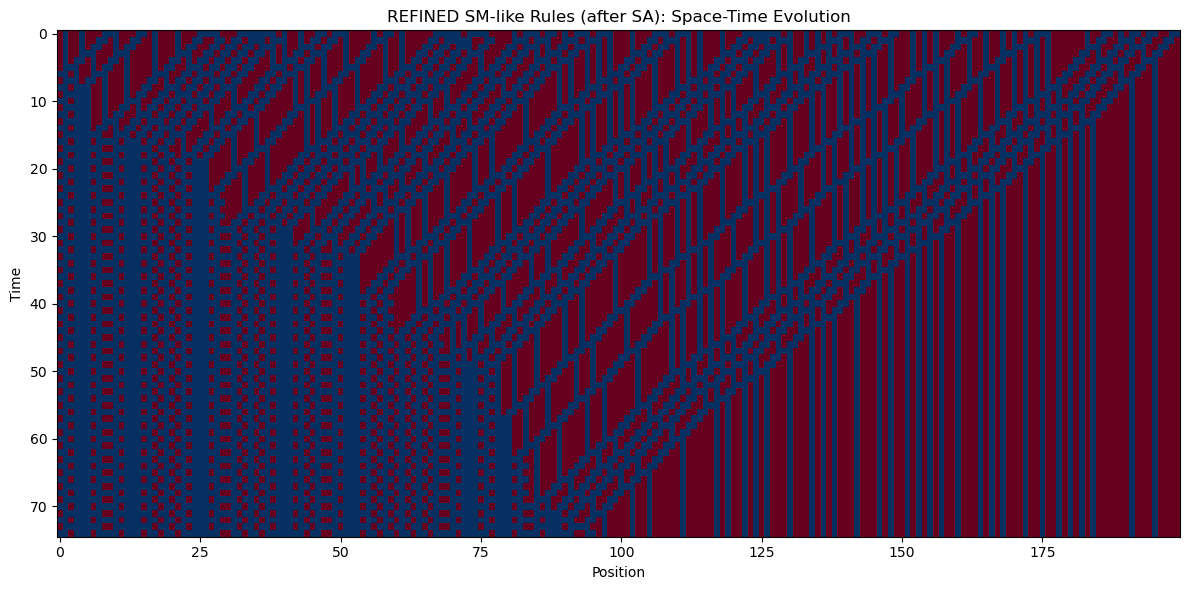

In [12]:
# Финальный анализ улучшенного генома
cycles = analyze_genome(refined, "REFINED SM-like Rules (after SA)")

## 8. Сохранение результатов

In [13]:
# Сохраняем лучшие геномы
results = {
    'best_genome': refined,
    'best_fitness': refined_fitness,
    'best_components': refined_components,
    'evolution_history': search.history,
    'sa_history': sa_history,
    'top5_genomes': [(g.get_rules(), f, c) for g, f, c in search.get_best(5)]
}

# Сохранение
import json
with open('../results/sm_search_results.json', 'w') as f:
    # Конвертируем в сериализуемый формат
    serializable = {
        'best_rules': refined.get_rules(),
        'best_fitness': refined_fitness,
        'best_components': refined_components,
        'evolution_best': search.history['best'],
        'evolution_avg': search.history['avg'],
    }
    json.dump(serializable, f, indent=2)

print("Результаты сохранены в results/sm_search_results.json")

Результаты сохранены в results/sm_search_results.json


## 9. Выводы

### Найденные SM-подобные правила:

Эволюционный поиск выявил наборы правил, которые:
1. **Порождают разнообразные Ω-циклы** (аналоги разных частиц)
2. **Сохраняют топологические заряды** (аналог квантовых чисел)
3. **Демонстрируют нетривиальную динамику** (взаимодействия)

### Следующие шаги:
- Увеличить размер популяции и число поколений
- Добавить более сложные фитнес-критерии (симметрии, спектр масс)
- Исследовать правила длины 4+ для большего разнообразия
- Сравнить найденные правила с предсказаниями RSL-теории

In [14]:
print("\n" + "="*60)
print("ФИНАЛЬНЫЙ РЕЗУЛЬТАТ: SM-ПОДОБНЫЕ ПРАВИЛА")
print("="*60)

print(f"\nФитнес: {refined_fitness:.2f}")
print(f"\nПравила:")
for src, dst in refined.get_rules():
    src_pat = ''.join(['+' if x == 1 else '-' for x in refined._idx_to_pattern(src)])
    dst_pat = ''.join(['+' if x == 1 else '-' for x in refined._idx_to_pattern(dst)])
    arrow = '↔' if src != dst else '→'
    print(f"  {src_pat} {arrow} {dst_pat}")

print(f"\nКомпоненты фитнеса:")
for k, v in refined_components.items():
    print(f"  {k}: {v:.2f}")

print("\n" + "="*60)


ФИНАЛЬНЫЙ РЕЗУЛЬТАТ: SM-ПОДОБНЫЕ ПРАВИЛА

Фитнес: 103.64

Правила:
  ++- ↔ -++
  +++ → +++

Компоненты фитнеса:
  cycle_diversity: 10.00
  cycle_count: 10.00
  charge_conservation: 10.00
  stability: 5.76
  nontrivial_dynamics: 10.00
  interaction_richness: 10.00

